# \[Plots Only\]: Radial Dependency of Seismo-Acoustic Signals

In [1]:
import asdf
import numpy as np
import pandas as pd
from IPython.display import JSON
from scipy import signal as sig
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import seaborn as sbn
%matplotlib inline
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', size=10)

In [2]:
SAVEFIGS = False

## load data

In [3]:
DLOC = Path('../data')

pltt = sbn.color_palette([
    '#2271B2', '#D55E00', '#359B73', '#E20134', '#A40122', '#000000'])
sbn.set_palette(pltt)
pltt

[(0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (0.0, 0.0, 0.0)]

In [4]:
import datarepo
from datarepo import xyz, xy, byu_chpmap, byu_pchmap, byu_ch
pos = datarepo.get_pos()
byu_mics = datarepo.get_byu_mics()
msumm = datarepo.get_byu_mics_summ()

af = asdf.open(DLOC / 'UCSB_seis_inf/asdf/seis_inf.asdf', mode='rw')
af.find_references()

In [5]:
af.info(40)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): Space Telescope Science Institute
│ ├─homepage (str): http://github.com/spacetelescope/asdf
│ ├─name (str): asdf
│ └─version (str): 2.7.1
├─history (dict)
│ └─extensions (list)
│   └─[0] (ExtensionMetadata) ...
├─comment (dict)
│ └─anl/ucsb_seis_inf_to_asdf.ipynb (dict)
│   ├─note (str): asdf data from "raw" UCSB MINISEED.
  - Raw data is cropped to 20 s window (truncated)
│   └─run_after (list) ...
├─pad1 (dict)
│ ├─ascii_off (float): 1.8025
│ ├─inf (dict)
│ │ ├─1 (dict) ...
│ │ ├─2 (dict) ...
│ │ └─3 (dict) ...
│ ├─seis (dict)
│ │ ├─1 (dict) ...
│ │ ├─2 (dict) ...
│ │ └─5 not shown
│ └─t (Reference)
├─pad2 (dict)
│ ├─ascii_off (float): 3.425
│ ├─inf (dict) ...
│ ├─seis (dict) ...
│ └─t (Reference)
├─pad3 (dict)
│ ├─ascii_off (float): 6.985
│ ├─inf (dict) ...
│ ├─seis (dict) ...
│ └─t (Reference)
└─pad4 (dict)
  ├─ascii_off (float): 2.6825
  ├─inf (dict) ...
  ├─seis (dict) ...
  └─t (Reference)
Some nodes not shown.


Summary table for infrasound

### `posmap`

Line numbers of pad- and sensor locations in the `pos` table:

In [6]:
posmap = {
    'pad': {1: [6, 7, 8], 2: [10, 11, 12], 3: [13, 14, 15], 4: [17, 18, 19]},
    'inf': {1: {1: 129, 2: 130, 3: 131}, 2: {1: 132, 2: 133, 3: 134},
            3: {1: 135, 2: 136, 3: 137}},
    'seis': {1: 122, 2: 123, 3: 124, 4: 125, 5: 126, 6: 127, 7: 128}
}

In [7]:
ssumm = pd.DataFrame(
    data=np.nan, index=pd.RangeIndex(4 * 6 * 2),
    columns=['pad', 'blast', 'ch', 'vmax', 'tmax', 'vmin', 'tmin']
)
ssumm.head(1)

pad  blast  ch  vmax  tmax  vmin  tmin
0  NaN    NaN NaN   NaN   NaN   NaN   NaN

- `srate`: sampling rate of sismics/inf
- `msrate`: sampling rate of acoustics

In [8]:
srate = 400.
msrate = 204800.

infch = {1: [1, 2, 3], 2: [1, 2, 3], 3: [1, 2, 3]}
seisch = {i: ['hhe', 'hhn', 'hhz'] for i in range(1, 8)}

## Helper Funcs

### `norm()`

Normalize an array to it's RMS

In [9]:
def norm(data):
    return data / np.sqrt(np.trapz(data ** 2, axis=0) / len(data))

## Plotting

### `r_plot()`

In [10]:
fhp = .5
default_filtpars = dict(freq=fhp, order=4)

def r_plot(r, t, data, amp, ax, clr, showch=False, lbls=None, xlim=None):
    ln = data.shape[1]
    opts = dict(lw=.5, color=clr)
    xlim = (t[0], t[-1]) if xlim is None else xlim
    ax.set_xlim(xlim)
    ax.set_yticks([0, 30, 80, 130, 180, 230, 280, 330])
    for i in range(ln):
        if showch:
            ax.text(xlim[0] + .025 * (xlim[0] + xlim[1]), r[i] + 3,
                    s=lbls[i], color=clr, fontsize=10, va='bottom')
        y = amp * norm(data[:, i]) + r[i]
        ax.plot(t, y, **opts)
    ax.set_ylim(-10, 380)
    ax.set_ylabel(r'$r\ /\ \mathrm{m}$')

### `plot_pulses()`

In [11]:
def plot_pulses(axs, mics, meta, chs=[7, 22, 17, 19, 21, 25],
                ylabels=True, rlabels=True, tweaks=None):
    ts = meta.set_index('ch').loc[:, 'ts']
    rs = meta.set_index('ch').loc[:, 'r']
    t = mics[7]['t']
    if tweaks is None:
        tweaks = len(chs) * [None]
    for i, (ch, tweak) in enumerate(zip(chs, tweaks), start=1):
        ax = axs[i - 1]
        if ch == -1:
            ax.set_xticks([])
            continue
        start, end = int(msrate * (ts[ch] - 2e-3)), int(msrate * (ts[ch] + 2e-2))
        y = mics[ch]['x'][start:end]
        if tweak == 'detrend':
            y = sig.detrend(y, type='linear')
        elif tweak is None:
            y = y - y[0]
        ax.plot(t[start:end], y, color=pltt[0])
        if rlabels:
            ax.text(1.05, .5, s=r'$r=%.0f\,\mathrm{m}$' % (rs[ch]),
                    transform=ax.transAxes, ha='center', va='top',
                    rotation=90, rotation_mode='anchor')
        if ylabels:
            ax.set_ylabel(r'$p\ /\ \mathrm{Pa}$')
    axs[-1].set_xlabel(r'$t\ /\ \mathrm{s}$')
    ax.figure.align_ylabels()

### `ea_es_plot()`

In [12]:
def ea_es_plot(inf, seis, t, figaxs=None, set_size=True, pci=0):
    if figaxs is None:
        fig, axs = plt.subplots(nrows=2, sharex=True)
    else:
        fig, axs = figaxs
    ax1, ax2 = axs
    ax1.plot(t, inf ** 2, color=pltt[pci])
    ax1.set_ylabel(r'$p^2\ /\ \mathrm{Pa^2}$')
    vsq = np.zeros(len(seis['hhz']))
    for comp in ['hhn', 'hhe', 'hhz']:
        vsq += seis[comp] ** 2
    ax2.plot(t, vsq * 1e6, color=pltt[pci])
    ax2.set_ylabel(r'$u^2\ /\ 10^{-6}\mathrm{m^2s^{-2}}$')
    ax2.set_xlabel(r'$t\ /\ \mathrm{s}$')
    fig.subplots_adjust(hspace=0)
    if set_size:
        fig.set_size_inches(6.5, 8)
    return fig, axs

### `add_char_label()`

In [13]:
def add_char_label(lbl, ax, txtclr='white', bc='#a5a5a5'):
    try:
        dpi = ax.figure.get_dpi()
    except AttributeError:
        dpi = ax.figure.figure.get_dpi()
    pnts = ax.transAxes.transform([(0, 0), (1, 1)])
    sfx = dpi / (72 * (pnts[1, 0] - pnts[0, 0]))
    sfy = dpi / (72 * (pnts[1, 1] - pnts[0, 1]))
    ax.add_artist(plt.Rectangle(
        (-50 * sfx, 1. - 15 * sfy), 11 * sfx, 15 * sfy,
        transform=ax.transAxes, ec='none', fc=bc, clip_on=False
    ))
    ax.text(-45 * sfx, 1 - 8 * sfy, lbl, ha='center', va='center',
            transform=ax.transAxes, color=txtclr)

In [14]:
def get_sten(start, end, off, sr):
    return int(sr * (start + off)), int(sr * (end + off))

In [15]:
seis_comps = {'r': 'n', 't': 'e', 'z': 'z'}

In [16]:
byu_ch['rline']['h']

array([ 7, 22, 17, 19, 21, 25, 27, 29])

In [17]:
byu_ch['rline']['l']

array([ 6, 15, 14, 16, 18, 20, 24, 26, 28])

## Pad 1

### Setup Data

In [18]:
ccenter = pos.loc[posmap['pad'][1], xyz].sum(axis=0) / 3
mics = byu_mics['pad1']
start, end = 0., 6.

#### Acoustic

In [19]:
mst, men = get_sten(start, end, 0, msrate)
mch = [7, 17, 19, 20, 25, 27, 29]  # ch 21 is not good in pad 1
micsig = np.empty((men - mst, len(mch)))

In [20]:
mt = mics[7]['t'][mst:men]
mt[:5]

array([0.00000000e+00, 4.88281250e-06, 9.76562500e-06, 1.46484375e-05,
       1.95312500e-05])

Bandpass filter at .5 Hz 'in' and 10 kHz 'out'

In [21]:
bmic, amic = sig.bessel(2, np.array([5., 1e4]) / (.5 * msrate),
                        btype='bandpass', analog=False, output='ba')
for i, ch in enumerate(mch):
    micsig[:, i] = sig.filtfilt(bmic, amic, mics[ch]['x'][mst:men])

In [22]:
r_m = []
for ch in mch:
    r = np.nan
    try:
        r = msumm.query(f'pad == 1 & ch == {ch}')['r'].iloc[0]
    except IndexError:
        pass
    if np.isnan(r):
        r = mics[ch]['chRPad']
    r_m.append(r)
r_m = np.asarray(r_m)

#### Infrasound

In [23]:
ls -l ../data/UCSB_seis_inf/DATA/DATA_ASCII_amp/BLAST1/DDF/

total 2052
-rw-r--r-- 1 ingo ingo 232992 Oct 19  2018 BUF.NYI11.DDF.txt
-rw-r--r-- 1 ingo ingo 232992 Oct 19  2018 BUF.NYI12.DDF.txt
-rw-r--r-- 1 ingo ingo 232992 Oct 19  2018 BUF.NYI13.DDF.txt
-rw-r--r-- 1 ingo ingo 232992 Oct 19  2018 BUF.NYI21.DDF.txt
-rw-r--r-- 1 ingo ingo 232992 Oct 19  2018 BUF.NYI22.DDF.txt
-rw-r--r-- 1 ingo ingo 232992 Oct 19  2018 BUF.NYI23.DDF.txt
-rw-r--r-- 1 ingo ingo 232992 Oct 19  2018 BUF.NYI31.DDF.txt
-rw-r--r-- 1 ingo ingo 232992 Oct 19  2018 BUF.NYI32.DDF.txt
-rw-r--r-- 1 ingo ingo 232992 Oct 19  2018 BUF.NYI33.DDF.txt


In [24]:
seac = af['pad1']
st, en = get_sten(start, end, seac['ascii_off'], srate)

In [25]:
t = seac['t'][st:en] - seac['ascii_off']
t[:5]

array([0.    , 0.0025, 0.005 , 0.0075, 0.01  ])

In [26]:
en - st

2400

In [27]:
infchns = [[1, 2], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]]

In [28]:
infsig = np.empty((len(t), len(infchns)))

In [29]:
binf, ainf = sig.bessel(
    2, .5 / (.5 * srate), btype='highpass', analog=False, output='ba')
for k, (i, j) in enumerate(infchns):
    rsig = np.loadtxt(
        f'../data/UCSB_seis_inf/DATA/DATA_ASCII_amp/BLAST1/DDF/BUF.NYI{i}{j}.DDF.txt',
        max_rows=en - st)[:, 1]
    infsig[:, k] = sig.filtfilt(binf, ainf, rsig)

In [30]:
pos.loc[122:137, ['label'] + xyz]

label          x           y       z
point                                      
122    NYS01  28.608807   27.665186 -0.7798
123    NYS02  24.301585  -32.956018 -3.0374
124    NYS03  25.210863  -83.768950 -1.7690
125    NYS04  26.120449 -134.581957  2.8392
126    NYS05  19.772250 -181.535218  2.1016
127    NYS06  20.682395 -232.348372  0.5769
128    NYS07  26.808858 -273.353153 -1.7344
129    NYI11  44.257375   57.090228 -1.4825
130    NYI12  28.608807   27.665186 -0.7798
131    NYI13  -7.680367   46.964317 -7.2449
132    NYI21  24.301585  -32.956018 -3.0374
133    NYI22  25.210863  -83.768950 -1.7690
134    NYI23  26.120449 -134.581957  2.8392
135    NYI31  19.772250 -181.535218  2.1016
136    NYI32  20.682395 -232.348372  0.5769
137    NYI33  26.808858 -273.353153 -1.7344

In [31]:
r_i = np.asarray([
    np.sqrt(np.sum((ccenter - pos.loc[posmap['inf'][i][j], xyz]) ** 2))
    for i, j in infchns
])
r_i

array([ 26.85265561,  84.79173355, 135.49609735, 186.31660088,
       233.00799435, 283.81079245, 324.94944039])

#### Seismic

Uses same time line as infrasound

In [32]:
comp = 'r'
amp_s = 4.5
compkey = seis_comps[comp] if comp in seis_comps.keys() else comp

In [33]:
seissig = np.empty((en - st, 7))

In [34]:
bseis, aseis = sig.bessel(
    2, .5 / (.5 * srate), btype='highpass', analog=False, output='ba')
for i in range(1, 8):
    seissig[:, i - 1] = sig.filtfilt(
        bseis, aseis, seac['seis'][i][f'hh{compkey}'][st:en])

In [35]:
r_s = np.sqrt(np.sum((ccenter - pos.loc[122:128, xyz]) ** 2, axis=1)).values
r_s

array([ 26.85265561,  84.79173355, 135.49609735, 186.31660088,
       233.00799435, 283.81079245, 324.94944039])

### Plot

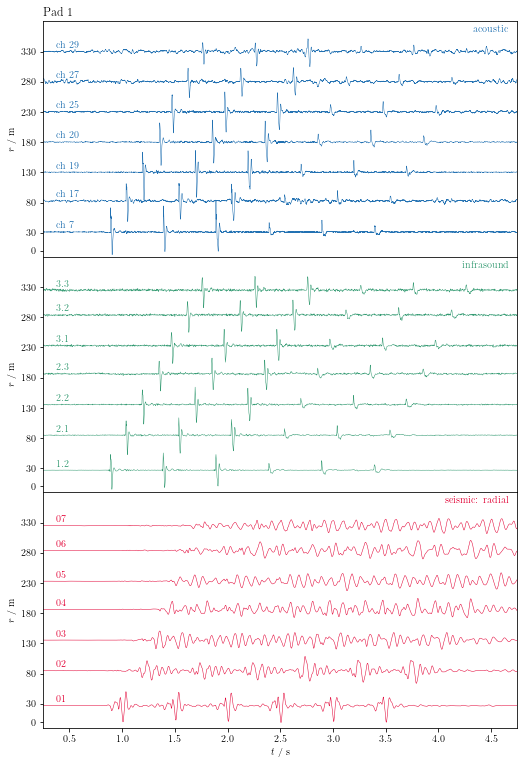

In [36]:
fig, axs = plt.subplots(nrows=3, sharex=True)

xlim = (.25, 4.75)

ax = axs[0]
ax.set_title('Pad 1', loc='left')
ax.text(.98, .98, s='acoustic', color=pltt[0], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_m, mt, micsig, 3, ax, pltt[0],
       True, lbls=[f'ch {ch}' for ch in mch], xlim=xlim)

ax = axs[1]
ax.text(.98, .98, s='infrasound', color=pltt[2], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_i, t, infsig, 2.5, ax, pltt[2],
       True, lbls=[f'{i}.{j}' for i, j in infchns], xlim=xlim)

ax = axs[2]
ax.text(.98, .98, s='seismic: radial', color=pltt[3], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_s, t, seissig, amp_s, ax, pltt[3],
       True, lbls=[f'{i:02d}' for i in range(1, 8)], xlim=xlim)
ax.set_xlabel(r'$t\ /\ \mathrm{s}$')

fig.subplots_adjust(hspace=0)
fig.set_size_inches(8.5, 13)

In [37]:
if SAVEFIGS:
    fig.savefig('graphs/seis_acoust_rplot_p1.pdf', dpi=300)
    fig.savefig('graphs/seis_acoust_rplot_p1.png', dpi=300)

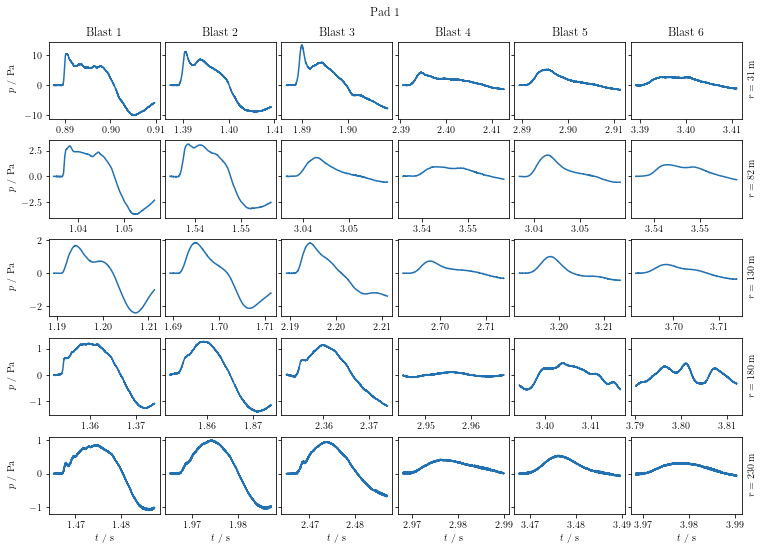

In [38]:
fig, axs = plt.subplots(nrows=5, ncols=6, sharey='row', figsize=(11, 8))
# [7, 17, 19, 20, 25, 27, 29]

plot_pulses(axs[:, 0], mics, chs=[7, 17, 19, 21, 25],
            meta=msumm.query('pad == 1 & blast == 1'),
            ylabels=True, rlabels=False)
plot_pulses(axs[:, 1], mics, chs=[7, 17, 19, 21, 25],
            meta=msumm.query('pad == 1 & blast == 2'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 2], mics,  chs=[7, 17, 19, 21, 25],
            meta=msumm.query('pad == 1 & blast == 3'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 3], mics, chs=[7, 17, 19, 21, 25],
            meta=msumm.query('pad == 1 & blast == 4'),
            ylabels=False, rlabels=False,
           tweaks=[None, None, None, 'detrend', None])
plot_pulses(axs[:, 4], mics, chs=[7, 16, 19, 21, 25],
            meta=msumm.query('pad == 1 & blast == 5'),
            ylabels=False, rlabels=False,
            tweaks=[None, None, None, 'detrend', None])
plot_pulses(axs[:, 5], mics,  chs=[7, 16, 19, 21, 25],
            meta=msumm.query('pad == 1 & blast == 6'),
            ylabels=False,
            tweaks=[None, None, None, 'detrend', None])
for i in range(1, 7):
    axs[0, i - 1].set_title(f'Blast {i}')

fig.suptitle('Pad 1')
fig.subplots_adjust(hspace=.28, wspace=.05, top=.92, bottom=.1, left=.075, right=.95)

In [39]:
if SAVEFIGS:
    fig.savefig('graphs/waveforms_grid_p1.pdf', dpi=300)
    fig.savefig('graphs/waveforms_grid_p1.png', dpi=300)    

## Pad 2

### Setup Data

In [40]:
ccenter = pos.loc[posmap['pad'][2], xyz].sum(axis=0) / 3
mics = byu_mics['pad2']
start, end = 0., 6.

#### Acoustic

In [41]:
mst, men = get_sten(start, end, 0, msrate)
mch = [ 7, 17, 19, 21, 25, 27, 29]
micsig = np.empty((men - mst, len(mch)))

In [42]:
mt = mics[7]['t'][mst:men]
mt[:5]

array([0.00000000e+00, 4.88281250e-06, 9.76562500e-06, 1.46484375e-05,
       1.95312500e-05])

Bandpass filter at .5 Hz 'in' and 10 kHz 'out'

In [43]:
bmic, amic = sig.bessel(2, np.array([5., 1e4]) / (.5 * msrate),
                        btype='bandpass', analog=False, output='ba')
for i, ch in enumerate(mch):
    micsig[:, i] = sig.filtfilt(bmic, amic, mics[ch]['x'][mst:men])

In [44]:
r_m = []
for ch in mch:
    r = np.nan
    try:
        r = msumm.query(f'pad == 2 & ch == {ch}')['r'].iloc[0]
    except IndexError:
        pass
    if np.isnan(r):
        r = mics[ch]['chRPad']
    r_m.append(r)
r_m = np.asarray(r_m)
r_m

array([ 29.78268593,  81.95413854, 130.27758825, 180.20058268,
       230.15701162, 280.12898815, 330.10945155])

#### Infrasound

In [45]:
seac = af['pad2']
st, en = get_sten(start, end, seac['ascii_off'], srate)

In [46]:
t = seac['t'][st:en] - seac['ascii_off']
t[:5]

array([0.    , 0.0025, 0.005 , 0.0075, 0.01  ])

In [47]:
en - st

2400

In [48]:
infchns = [[1, 2], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]]

In [49]:
infsig = np.empty((len(t), len(infchns)))

In [50]:
binf, ainf = sig.bessel(
    2, .5 / (.5 * srate), btype='highpass', analog=False, output='ba')
for k, (i, j) in enumerate(infchns):
    rsig = seac['inf'][i][j][st:en]
    infsig[:, k] = sig.filtfilt(binf, ainf, rsig)

In [51]:
r_i = np.asarray([
    np.sqrt(np.sum((ccenter - pos.loc[posmap['inf'][i][j], xyz]) ** 2))
    for i, j in infchns
])
r_i

array([ 24.32177426,  83.79759215, 134.59323007, 185.45521156,
       232.31962922, 283.11145619, 324.16279284])

#### Seismic

Uses same time line as infrasound

In [52]:
comp = 'r'
amp_s = 4.5
compkey = seis_comps[comp] if comp in seis_comps.keys() else comp

In [53]:
seissig = np.empty((en - st, 7))

In [54]:
bseis, aseis = sig.bessel(
    2, .5 / (.5 * srate), btype='highpass', analog=False, output='ba')
for i in range(1, 8):
    seissig[:, i - 1] = sig.filtfilt(
        bseis, aseis, seac['seis'][i][f'hh{compkey}'][st:en])

In [55]:
r_s = np.sqrt(np.sum((ccenter - pos.loc[122:128, xyz]) ** 2, axis=1)).values
r_s

array([ 24.32177426,  83.79759215, 134.59323007, 185.45521156,
       232.31962922, 283.11145619, 324.16279284])

### Plot

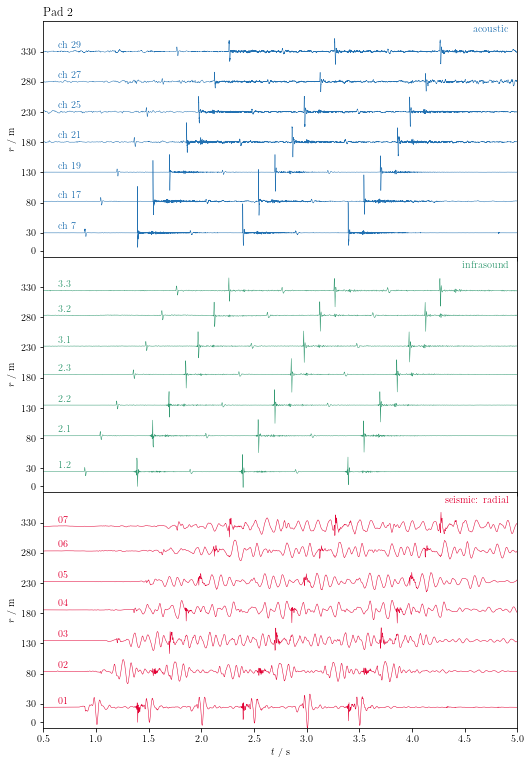

In [56]:
fig, axs = plt.subplots(nrows=3, sharex=True)

xlim = (.5, 5.)

ax = axs[0]
ax.set_title('Pad 2', loc='left')
ax.text(.98, .98, s='acoustic', color=pltt[0], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_m, mt, micsig, 1.5, ax, pltt[0],
       True, lbls=[f'ch {ch}' for ch in mch], xlim=xlim)

ax = axs[1]
ax.text(.98, .98, s='infrasound', color=pltt[2], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_i, t, infsig, 1.5, ax, pltt[2],
       True, lbls=[f'{i}.{j}' for i, j in infchns], xlim=xlim)

ax = axs[2]
ax.text(.98, .98, s='seismic: radial', color=pltt[3], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_s, t, seissig, amp_s, ax, pltt[3],
       True, lbls=[f'{i:02d}' for i in range(1, 8)], xlim=xlim)
ax.set_xlabel(r'$t\ /\ \mathrm{s}$')

fig.subplots_adjust(hspace=0)
fig.set_size_inches(8.5, 13)

In [57]:
if SAVEFIGS:
    fig.savefig('graphs/seis_acoust_rplot_p2.pdf', dpi=300)
    fig.savefig('graphs/seis_acoust_rplot_p2.png', dpi=300)

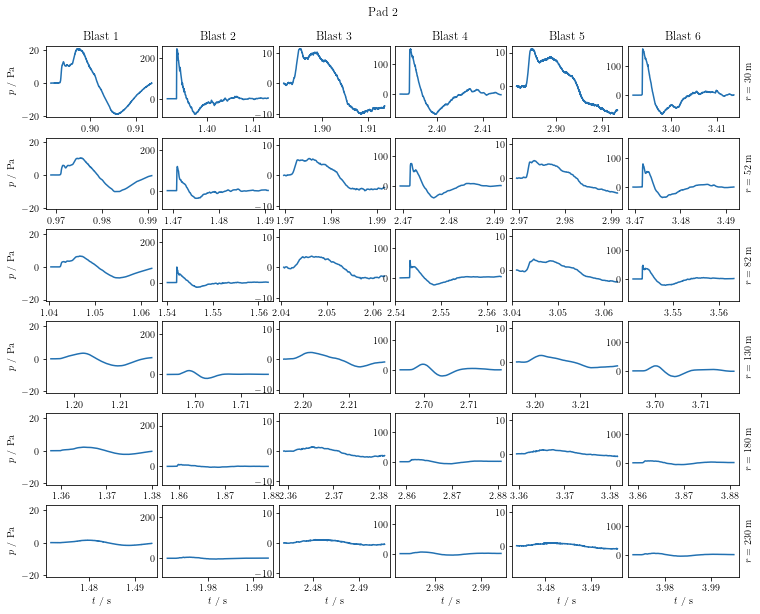

In [58]:
fig, axs = plt.subplots(nrows=6, ncols=6, sharey='col', figsize=(11, 9))

plot_pulses(axs[:, 0], mics,
            meta=msumm.query('pad == 2 & blast == 1 & hlabel == "h"'),
            ylabels=True, rlabels=False)
plot_pulses(axs[:, 1], mics,
            meta=msumm.query('pad == 2 & blast == 2 & hlabel == "h"'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 2], mics, chs=[7, 22, 17, 19, 21, 25],
            meta=msumm.query('pad == 2 & blast == 3 & hlabel == "h"'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 3], mics,
            meta=msumm.query('pad == 2 & blast == 4 & hlabel == "h"'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 4], mics,
            meta=msumm.query('pad == 2 & blast == 5 & hlabel == "h"'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 5], mics, chs=[7, 22, 17, 19, 21, 25],
            meta=msumm.query('pad == 2 & blast == 6 & hlabel == "h"'),
            ylabels=False)
for i in range(1, 7):
    axs[0, i - 1].set_title(f'Blast {i}')

fig.suptitle('Pad 2')
fig.subplots_adjust(hspace=.28, wspace=.05, top=.92, bottom=.1, left=.075, right=.95)

In [59]:
if SAVEFIGS:
    fig.savefig('graphs/waveforms_grid_p2.pdf', dpi=300)
    fig.savefig('graphs/waveforms_grid_p2.png', dpi=300)    

## Pad 3

### Setup Data

In [60]:
ccenter = pos.loc[posmap['pad'][3], xyz].sum(axis=0) / 3
mics = byu_mics['pad3']
start, end = 0., 6.

#### Acoustic

In [61]:
mst, men = get_sten(start, end, 0, msrate)
mch = [ 7, 17, 19, 20, 25, 27, 29]  # ch 21 not good...
micsig = np.empty((men - mst, len(mch)))

In [62]:
mt = mics[7]['t'][mst:men]
mt[:5]

array([0.00000000e+00, 4.88281250e-06, 9.76562500e-06, 1.46484375e-05,
       1.95312500e-05])

Bandpass filter at .5 Hz 'in' and 10 kHz 'out'

In [63]:
bmic, amic = sig.bessel(2, np.array([5., 1e4]) / (.5 * msrate),
                        btype='bandpass', analog=False, output='ba')
for i, ch in enumerate(mch):
    micsig[:, i] = sig.filtfilt(bmic, amic, mics[ch]['x'][mst:men])

In [64]:
r_m = []
for ch in mch:
    r = np.nan
    try:
        r = msumm.query(f'pad == 3 & ch == {ch}')['r'].iloc[0]
    except IndexError:
        pass
    if np.isnan(r):
        r = mics[ch]['chRPad']
    r_m.append(r)
r_m = np.asarray(r_m)
r_m

array([ 28.07936827,  80.71157692, 130.27758825, 180.15618252,
       230.15701162, 280.12898815, 330.10945155])

#### Infrasound

In [65]:
seac = af['pad3']
st, en = get_sten(start, end, seac['ascii_off'], srate)

In [66]:
t = seac['t'][st:en] - seac['ascii_off']
t[:5]

array([0.    , 0.0025, 0.005 , 0.0075, 0.01  ])

In [67]:
infchns = [[1, 2], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]]

In [68]:
infsig = np.empty((len(t), len(infchns)))

In [69]:
binf, ainf = sig.bessel(
    2, .5 / (.5 * srate), btype='highpass', analog=False, output='ba')
for k, (i, j) in enumerate(infchns):
    rsig = seac['inf'][i][j][st:en]
    infsig[:, k] = sig.filtfilt(binf, ainf, rsig)

In [70]:
r_i = np.asarray([
    np.sqrt(np.sum((ccenter - pos.loc[posmap['inf'][i][j], xyz]) ** 2))
    for i, j in infchns
])
r_i

array([ 23.17153305,  83.16972364, 133.97256874, 184.83824108,
       231.77213253, 282.55278836, 323.56113745])

#### Seismic

Uses same time line as infrasound

In [71]:
comp = 'r'
amp_s = 4.5
compkey = seis_comps[comp] if comp in seis_comps.keys() else comp

In [72]:
seissig = np.empty((en - st, 7))

In [73]:
bseis, aseis = sig.bessel(
    2, .5 / (.5 * srate), btype='highpass', analog=False, output='ba')
for i in range(1, 8):
    seissig[:, i - 1] = sig.filtfilt(
        bseis, aseis, seac['seis'][i][f'hh{compkey}'][st:en])

In [74]:
r_s = np.sqrt(np.sum((ccenter - pos.loc[122:128, xyz]) ** 2, axis=1)).values
r_s

array([ 23.17153305,  83.16972364, 133.97256874, 184.83824108,
       231.77213253, 282.55278836, 323.56113745])

### Plot

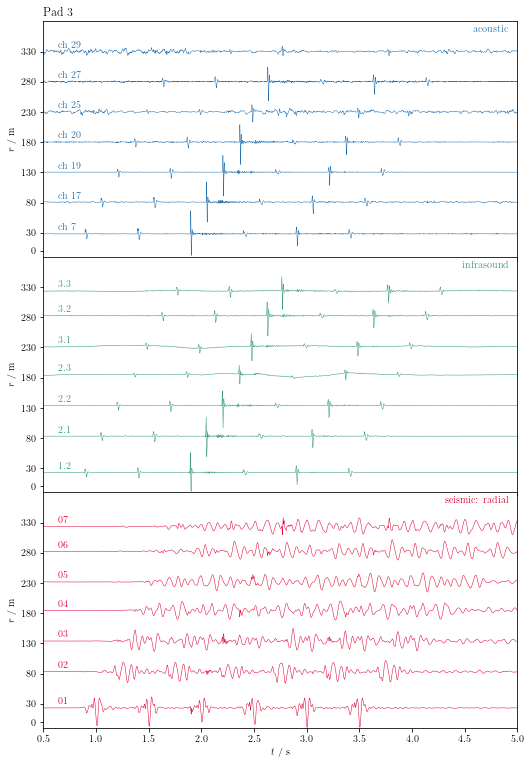

In [75]:
fig, axs = plt.subplots(nrows=3, sharex=True)

xlim = (.5, 5.)

ax = axs[0]
ax.set_title('Pad 3', loc='left')
ax.text(.98, .98, s='acoustic', color=pltt[0], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_m, mt, micsig, 1.5, ax, pltt[0],
       True, lbls=[f'ch {ch}' for ch in mch], xlim=xlim)

ax = axs[1]
ax.text(.98, .98, s='infrasound', color=pltt[2], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_i, t, infsig, 1.5, ax, pltt[2],
       True, lbls=[f'{i}.{j}' for i, j in infchns], xlim=xlim)

ax = axs[2]
ax.text(.98, .98, s='seismic: radial', color=pltt[3], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_s, t, seissig, amp_s, ax, pltt[3],
       True, lbls=[f'{i:02d}' for i in range(1, 8)], xlim=xlim)
ax.set_xlabel(r'$t\ /\ \mathrm{s}$')

fig.subplots_adjust(hspace=0)
fig.set_size_inches(8.5, 13)

In [76]:
if SAVEFIGS:
    fig.savefig('graphs/seis_acoust_rplot_p3.pdf', dpi=300)
    fig.savefig('graphs/seis_acoust_rplot_p3.png', dpi=300)

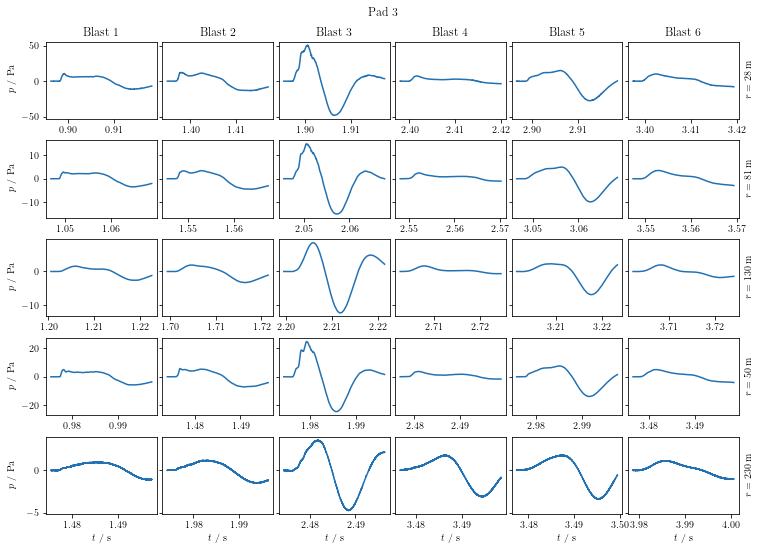

In [77]:
fig, axs = plt.subplots(nrows=5, ncols=6, sharey='row', figsize=(11, 8))
# [7, 17, 19, 20, 25, 27, 29]

plot_pulses(axs[:, 0], mics, chs=[7, 17, 19, 22, 25],
            meta=msumm.query('pad == 3 & blast == 1'),
            ylabels=True, rlabels=False)
plot_pulses(axs[:, 1], mics, chs=[7, 17, 19, 22, 25],
            meta=msumm.query('pad == 3 & blast == 2'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 2], mics,  chs=[7, 17, 19, 22, 25],
            meta=msumm.query('pad == 3 & blast == 3'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 3], mics, chs=[7, 17, 19, 22, 25],
            meta=msumm.query('pad == 3 & blast == 4'),
            ylabels=False, rlabels=False,
           tweaks=[None, None, None, None, None])
plot_pulses(axs[:, 4], mics, chs=[7, 16, 19, 22, 24],
            meta=msumm.query('pad == 3 & blast == 5'),
            ylabels=False, rlabels=False,
            tweaks=[None, None, None, None, None])
plot_pulses(axs[:, 5], mics,  chs=[7, 16, 19, 22, 24],
            meta=msumm.query('pad == 3 & blast == 6'),
            ylabels=False,
            tweaks=[None, None, None, None, None])
for i in range(1, 7):
    axs[0, i - 1].set_title(f'Blast {i}')

fig.suptitle('Pad 3')
fig.subplots_adjust(hspace=.28, wspace=.05, top=.92, bottom=.1, left=.075, right=.95)

In [78]:
if SAVEFIGS:
    fig.savefig('graphs/waveforms_grid_p3.pdf', dpi=300)
    fig.savefig('graphs/waveforms_grid_p3.png', dpi=300)    

## Pad 4

### Setup Data

In [79]:
ccenter = pos.loc[posmap['pad'][4], xyz].sum(axis=0) / 3
mics = byu_mics['pad4']
start, end = 0., 6.

#### Acoustic

In [80]:
mst, men = get_sten(start, end, 0, msrate)
mch = [ 15, 17, 19, 21, 25, 27, 29]  # ch 7 not good...
micsig = np.empty((men - mst, len(mch)))

In [81]:
mt = mics[7]['t'][mst:men]
mt[:5]

array([0.00000000e+00, 4.88281250e-06, 9.76562500e-06, 1.46484375e-05,
       1.95312500e-05])

Bandpass filter at .5 Hz 'in' and 10 kHz 'out'

In [82]:
bmic, amic = sig.bessel(2, np.array([5., 1e4]) / (.5 * msrate),
                        btype='bandpass', analog=False, output='ba')
for i, ch in enumerate(mch):
    micsig[:, i] = sig.filtfilt(bmic, amic, mics[ch]['x'][mst:men])

In [83]:
r_m = []
for ch in mch:
    r = np.nan
    try:
        r = msumm.query(f'pad == 4 & ch == {ch}')['r'].iloc[0]
    except IndexError:
        pass
    if np.isnan(r):
        r = mics[ch]['chRPad']
    r_m.append(r)
r_m = np.asarray(r_m)
r_m

array([ 26.8979255 ,  80.22001037, 130.27758825, 180.20058268,
       230.15701162, 280.12898815, 330.10945155])

#### Infrasound

In [84]:
seac = af['pad4']
st, en = get_sten(start, end, seac['ascii_off'], srate)

In [85]:
t = seac['t'][st:en] - seac['ascii_off']
t[:5]

array([0.    , 0.0025, 0.005 , 0.0075, 0.01  ])

In [86]:
infchns = [[1, 2], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]]

In [87]:
infsig = np.empty((len(t), len(infchns)))

In [88]:
binf, ainf = sig.bessel(
    2, .5 / (.5 * srate), btype='highpass', analog=False, output='ba')
for k, (i, j) in enumerate(infchns):
    rsig = seac['inf'][i][j][st:en]
    infsig[:, k] = sig.filtfilt(binf, ainf, rsig)

In [89]:
r_i = np.asarray([
    np.sqrt(np.sum((ccenter - pos.loc[posmap['inf'][i][j], xyz]) ** 2))
    for i, j in infchns
])
r_i

array([ 23.51935578,  83.41576861, 134.21994157, 185.0871518 ,
       232.00613507, 282.78904486, 323.80632391])

#### Seismic

Uses same time line as infrasound

In [90]:
comp = 'r'
amp_s = 4.5
compkey = seis_comps[comp] if comp in seis_comps.keys() else comp

In [91]:
seissig = np.empty((en - st, 7))

In [92]:
bseis, aseis = sig.bessel(
    2, .5 / (.5 * srate), btype='highpass', analog=False, output='ba')
for i in range(1, 8):
    seissig[:, i - 1] = sig.filtfilt(
        bseis, aseis, seac['seis'][i][f'hh{compkey}'][st:en])

In [93]:
r_s = np.sqrt(np.sum((ccenter - pos.loc[122:128, xyz]) ** 2, axis=1)).values
r_s

array([ 23.51935578,  83.41576861, 134.21994157, 185.0871518 ,
       232.00613507, 282.78904486, 323.80632391])

### Plot

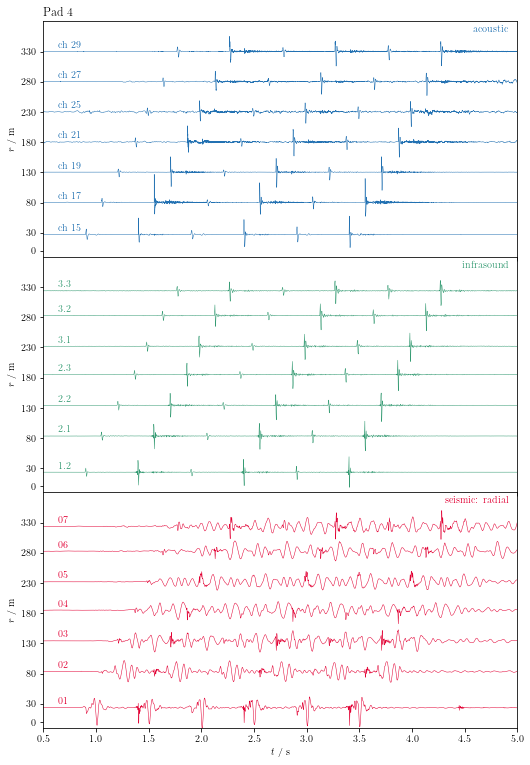

In [94]:
fig, axs = plt.subplots(nrows=3, sharex=True)

xlim = (.5, 5.)

ax = axs[0]
ax.set_title('Pad 4', loc='left')
ax.text(.98, .98, s='acoustic', color=pltt[0], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_m, mt, micsig, 1.5, ax, pltt[0],
       True, lbls=[f'ch {ch}' for ch in mch], xlim=xlim)

ax = axs[1]
ax.text(.98, .98, s='infrasound', color=pltt[2], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_i, t, infsig, 1.5, ax, pltt[2],
       True, lbls=[f'{i}.{j}' for i, j in infchns], xlim=xlim)

ax = axs[2]
ax.text(.98, .98, s='seismic: radial', color=pltt[3], ha='right', va='top',
        transform=ax.transAxes)
r_plot(r_s, t, seissig, amp_s, ax, pltt[3],
       True, lbls=[f'{i:02d}' for i in range(1, 8)], xlim=xlim)
ax.set_xlabel(r'$t\ /\ \mathrm{s}$')

fig.subplots_adjust(hspace=0)
fig.set_size_inches(8.5, 13)

In [95]:
if SAVEFIGS:
    fig.savefig('graphs/seis_acoust_rplot_p4.pdf', dpi=300)
    fig.savefig('graphs/seis_acoust_rplot_p4.png', dpi=300)

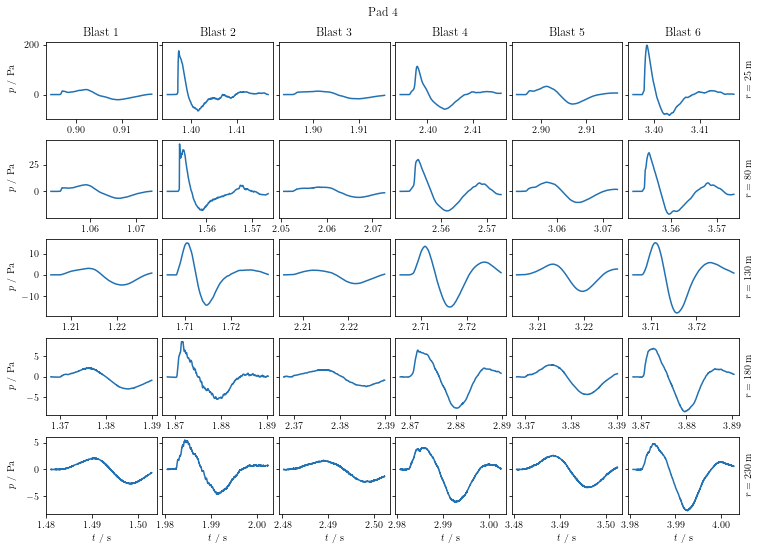

In [96]:
fig, axs = plt.subplots(nrows=5, ncols=6, sharey='row', figsize=(11, 8))

plot_pulses(axs[:, 0], mics, chs=[9, 17, 19, 21, 24],
            meta=msumm.query('pad == 4 & blast == 1'),
            ylabels=True, rlabels=False)
plot_pulses(axs[:, 1], mics, chs=[9, 17, 19, 21, 25],
            meta=msumm.query('pad == 4 & blast == 2'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 2], mics, chs=[9, 17, 19, 21, 25],
            meta=msumm.query('pad == 4 & blast == 3'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 3], mics, chs=[9, 17, 19, 21, 25],
            meta=msumm.query('pad == 4 & blast == 4'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 4], mics, chs=[9, 17, 19, 21, 25],
            meta=msumm.query('pad == 4 & blast == 5'),
            ylabels=False, rlabels=False)
plot_pulses(axs[:, 5], mics, chs=[9, 17, 19, 21, 25],
            meta=msumm.query('pad == 4 & blast == 6'),
            ylabels=False)
for i in range(1, 7):
    axs[0, i - 1].set_title(f'Blast {i}')

fig.suptitle('Pad 4')
fig.subplots_adjust(hspace=.28, wspace=.05, top=.92, bottom=.1, left=.075, right=.95)

In [97]:
if SAVEFIGS:
    fig.savefig('graphs/waveforms_grid_p4.pdf', dpi=300)
    fig.savefig('graphs/waveforms_grid_p4.png', dpi=300)    

## Squared Signals

In [98]:
start, end = 0., 6.

In [99]:
bmic, amic = sig.bessel(2, np.array([5., 1e4]) / (.5 * msrate),
                        btype='bandpass', analog=False, output='ba')
bseis, aseis = sig.bessel(
    2, .5 / (.5 * srate), btype='highpass', analog=False, output='ba')

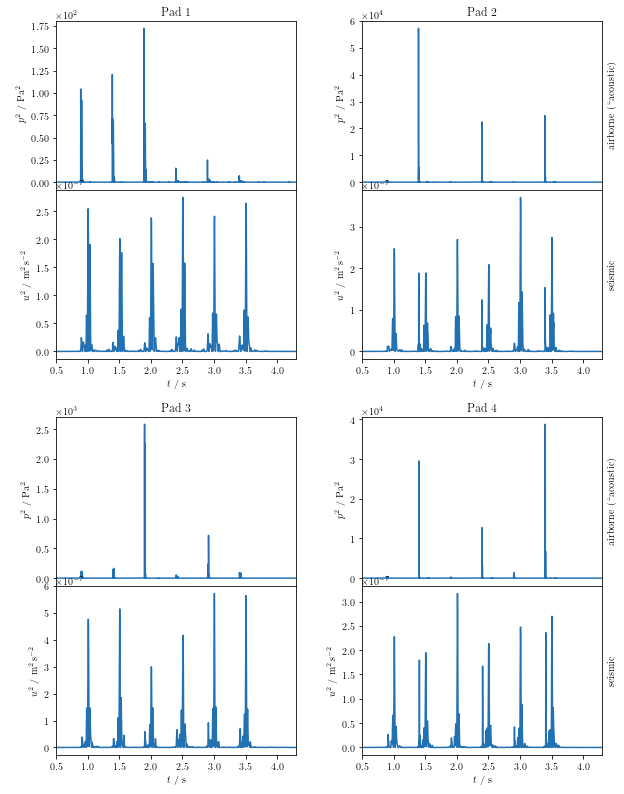

In [100]:
fig = plt.figure(figsize=(8.5, 11))
sfs = fig.subfigures(nrows=2, ncols=2).flatten()
sf1, sf2, sf3, sf4 = sfs

for pad, mch, sch in zip((1, 2, 3, 4), (7, 7, 7, 9), (1, 1, 1, 1)):
    mic = byu_mics[f'pad{pad}'][mch]
    mst, men = get_sten(start, end, 0, msrate)
    mt = mic['t'][mst:men]
    micsq = sig.filtfilt(bmic, amic, mic['x'][mst:men]) ** 2
    
    seac = af[f'pad{pad}']
    st, en = get_sten(start, end, seac['ascii_off'], srate)
    t = seac['t'][st:en] - seac['ascii_off']
    # whole velocity vector
    # seissq = np.zeros(len(t))
    # for comp in ('hhe', 'hhn', 'hhz'):
    #     seissq += sig.filtfilt(bseis, aseis, seac['seis'][sch][comp][st:en]) ** 2
    
    # radial component only
    seissq = sig.filtfilt(bseis, aseis, seac['seis'][sch]['hhn'][st:en]) ** 2
    
    subfig = sfs[pad - 1]
    ax1, ax2 = subfig.subplots(nrows=2, sharex=True)
    subfig.subplots_adjust(hspace=0, top=0.935, bottom=.08, left=.16, right=.945)
    ax1.set_title(f'Pad {pad}')
    ax1.plot(mt, micsq)
    ax1.set_ylabel(r'$p^2\ /\ \mathrm{Pa^2}$')
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1, 1))
    
    ax2.plot(t, seissq)
    ax2.set_ylabel(r'$u^2\ /\ \mathrm{m^2\,s^{-2}}$')
    ax2.set_xlim(.5, 4.3)
    ax2.set_xlabel(r'$t\ /\ \mathrm{s}$')
    if pad in (2, 4):
        ax1.text(1.02, 0.5, 'airborne (``acoustic'')', ha='center', va='top',
                 rotation=90, rotation_mode='anchor', transform=ax1.transAxes)
        ax2.text(1.02, 0.5, 'seismic', ha='center', va='top',
                 rotation=90, rotation_mode='anchor', transform=ax2.transAxes)

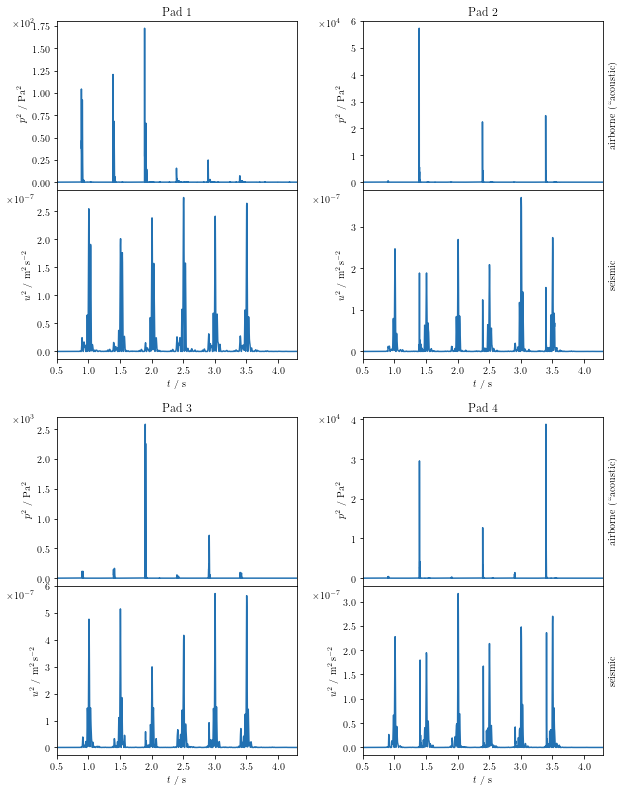

In [101]:
for subfig in sfs:
    for ax, (xpos, ypos) in zip(subfig.axes, ((-.09, .99), (-.09, .95))):
        ot = ax.yaxis.get_offset_text()
        ot.set_visible(False)
        ax.text(xpos, ypos, ot.get_text(), ha='right', va='center',
                transform=ax.transAxes)
fig

In [102]:
if SAVEFIGS:
    fig.savefig('graphs/squared_sigs_allpads.pdf', dpi=300)
    fig.savefig('graphs/squared_sigs_allpads.png', dpi=300)